<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
# %pip install pyautogen>=0.2.3

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [3]:
from typing import Dict, Union

from IPython import get_ipython
from IPython.display import display, Image

import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-0125-preview"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [4]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": True,  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    },
)

In [10]:
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

First, let's find out today's date using Python. Then, we will proceed to compare the year-to-date (YTD) gain for META (Facebook's parent company, Meta Platforms, Inc.) and TESLA (Tesla, Inc.).

```python
# Step 1: Get today's date
from datetime import datetime

# Print today's date
print(datetime.now().strftime('%Y-%m-%d'))
```

Please run this code to get today's date. After that, we will move on to the next step of comparing the YTD gains for META and TESLA.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
2024-02-05


--------------------------------------------------------------------------------
assistan

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto-generated.

## Example Task: Plot Chart

In [11]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the year-to-date (YTD) stock price change for META and TESLA and save it to `stock_price_ytd.png`, we will use Python with libraries such as `matplotlib` for plotting and `yfinance` for fetching the stock data. The following steps will be executed in the code:

1. Fetch YTD stock data for META and TESLA using `yfinance`.
2. Plot the closing prices of both stocks on the same chart.
3. Save the chart to a file named `stock_price_ytd.png`.

Please ensure you have `matplotlib` installed. If not, you can install it using pip:

```sh
pip install matplotlib
```

After ensuring `matplotlib` is installed, run the following Python code:

```python
# filename: plot_stock_price_ytd.py
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers and fet

Let's display the generated figure.

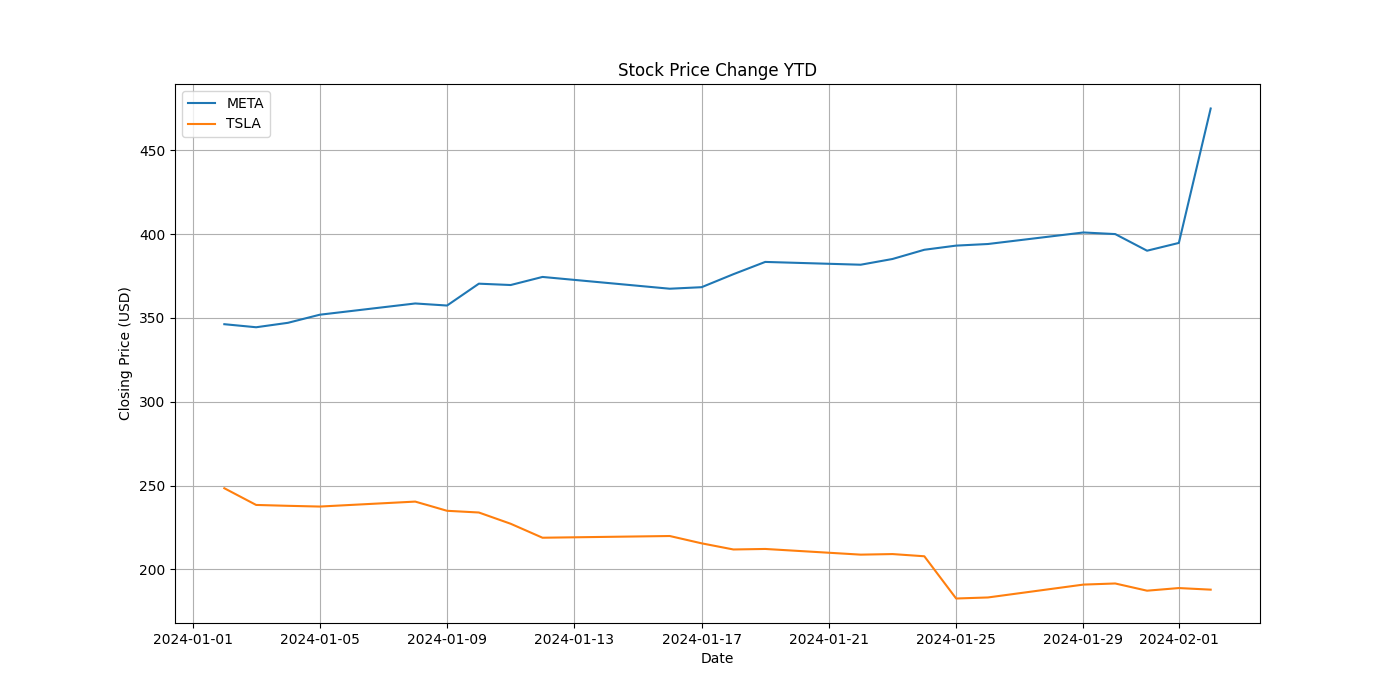

In [12]:
try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [6]:
class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return (
            super().generate_init_message(*args, **kwargs)
            + """
If you suggest code, the code will be executed in IPython."""
        )

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display the plot directly.

ipython_user_proxy (to assistant):

Plot a chart of META and TESLA stock price gain YTD
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

First, we need to install the necessary libraries to fetch stock data and plot the chart. Please execute the following code to install the required libraries:

```python
!pip install yfinance matplotlib
```

After installing the libraries, execute the following code to fetch the stock data and plot the chart:

```python
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Get the current date
today = datetime.date.today()

# Calculate the start date for YTD
start_date = datetime.date(today.year, 1, 1)

# Fetch stock data for META (Facebook) and TESLA
meta = yf.download('FB', start=start_date, end=today)
tesla = yf.download('TSLA', start=start_date, end=today)

# Calculate the percentage gain for each stock

IndexError: index 0 is out of bounds for axis 0 with size 0

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

It seems that there was an issue with fetching the stock data for META (Facebook) using the ticker symbol 'FB'. The stock symbol for META has been changed to 'META' recently. Let's update the code to use the new symbol and try again:

```python
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Get the current date
today = datetime.date.today()

# Ca

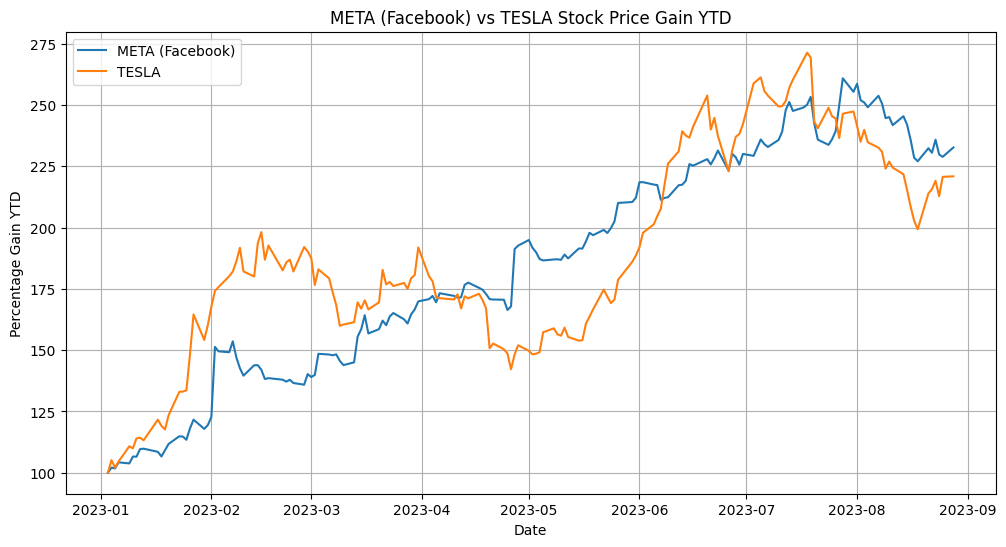

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

I'm glad the code executed successfully. You should now see a chart comparing the YTD percentage gain of META (Facebook) and TESLA stocks. If you have any further questions or need assistance with another task, feel free to ask.

TERMINATE

--------------------------------------------------------------------------------


In [7]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE")
    or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price gain YTD""",
)